In [1]:
# %reset 
# %clear
%pylab inline

Populating the interactive namespace from numpy and matplotlib


''

In [2]:
from os import sys
from scipy import stats

sys.path += ['/home/avalon/Code/C_Clustering/code']

from subprocess import run

escaper_bash = str.maketrans({"(":  r"\(", ")":  r"\)", " ":  r"\ ", "[":  r"\[", "]":  r"\]", "\\": r"\\", 
                               "^":  r"\^", "$":  r"\$", "*":  r"\*", ",":  r"\,", "{":  r"\{", "}":  r"\}",
                               "&": r"\&"})

In [3]:
# import scipy as scp

# import cvxpy as cvx

import pandas as pd

import builtins

# $\quad$ Para fins de compreensão e exposição, a tabela foi organizada da seguinte forma:

$\qquad$ 1 - Dividiu-se as colunas nos respectivos canais e marcas. Isso porque consegue-se ver melhor a correlação entre os dados nessa separação, útil para fins de reconstrução ou localização de anomalias e estruturas nelas.
    
$\qquad$ 2 - Daí, as linhas da tabela são referenciadas por período de ocorrência. Como se tratam de dados temporais, ainda que com mais atributos, essa organização permite isolar uma potencial sazonalidade de eventos mais naturalmente.

In [4]:
in_data_table = pd.read_csv ('brand_media_raw.csv', delimiter=',', parse_dates=True, 
                             infer_datetime_format=True, index_col='Date')

in_data_table.set_index (['Media', 'Brand'], append=True, inplace=True)
data_table = in_data_table.reorder_levels (['Media', 'Brand', 'Date']).sort_index ().astype (float)
data_table;

In [5]:
Medias, Brands, Dates = data_table.index.levels

In [6]:
Columns = data_table.columns
Columns;

In [7]:
sumary_periods = {'monthly': Dates.to_period ('M'), 'quarterly': Dates.to_period ('Q'), 'anual': Dates.to_period ('A')}

In [8]:
period_labels = {'monthly': 'Mensal', 'quarterly': 'Trimestral', 'anual': 'Anual'}

In [9]:
column_labels = {'Investment': 'Investimentos', 'NumVisits': 'Visitas', 
                 'NumUniqueVisits': 'Visitas Únicas', 'GrossSalesEstimate': 'Estimativas de vendas bruta', 
                 'GrossSalesPlaced': 'Vendas Postadas', 'GrossSalesApproved': 'Vendas Aprovadas', 
                 'QtyOrdersPlaced': 'Quantidade de Vendas Postadas','QtyOrdersApproved': 'Quantidade de Vendas Aprovadas'}

Uma amostra da formatação da tabela:

In [10]:
data_table.loc (axis=0)[3, :, Dates[:2]][Columns[:4]]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
3     0     2015-07-01   594274.56   419272.0         188104.0   
            2015-07-02  2041522.56   598080.0         276206.0   
      1     2015-07-01   183924.40    62482.0          28994.0   
            2015-07-02   340737.76   119938.0          57750.0   
      2     2015-07-01   165946.00    69818.0          30814.0   
            2015-07-02   322920.40   115066.0          53592.0   

                        GrossSalesEstimate  
Media Brand Date                            
3     0     2015-07-01          6777557.60  
            2015-07-02         12301457.52  
      1     2015-07-01          1499860.56  
            2015-07-02          2431011.44  
      2     2015-07-01          2193018.96  
            2015-07-02          2796456.08

# $\qquad$ O processo de análise seguirá assim:

$\qquad$ 1 - Agrupar os canais por tipo de anomalia. Isso cria uma repartição clara nos tipos de KPI's possíveis para cada canal.
    
$\qquad$ 2 - Para cada grupo são destrinchados e reportados potenciais fatores indicativos de desempenho de cada canal (por marca e cumulativo). Dentre esses KPI's estão a média de conversão dos investimentos em gerar tráfego (usando retorno bruto); ordens feitas e aprovadas. Além disso apresenta-se esses fatores em escala mensal, trimestral e anual, com margens de variância e desvios máximos e mínimos. A disponibilidade de tais fatores dependerá da suficiência dos dados.

In [11]:
def ratio_and_stats_tables (media, indicators_base, indicators_comparison, sumary_periods):
    media_table = data_table.loc [media]
    indicator_tables = {}

    for indicator in indicators_base:
        indicator_tables[indicator] = media_table[indicators_comparison[indicator]].div (media_table[indicator], axis='rows')

    indicator_frame = pd.concat (indicator_tables, axis=1)

    indicator_statisctics = {}

    for period in sumary_periods.keys ():
        indicator_frame.index.set_levels (sumary_periods[period], level='Date', inplace=True)

        indicator_statisctics[period] = {}

        indicator_statisctics[period]['per_brand'] = pd.concat ({brand :indicator_frame.loc[brand].groupby (level=-1).describe() 
                                                                 for brand in Brands}, axis=0).drop ('count', level=-1, axis=1).sort_index (axis=1)

        indicator_statisctics[period]['overall'] = indicator_frame.groupby (level=-1).describe().drop ('count', level=-1, axis=1).sort_index (axis=1)
    
    return indicator_tables, indicator_statisctics

In [12]:
sigma_multiple = 2
plot_labels = {'25%': 'quartil - 25%', '50%': 'quartil - 50%', '75%': 'quartil - 75%', 
               'max': 'máximo', 'mean': 'média', 'min': 'mínimo', 'std': 'margem  $\pm{:d}\sigma$'.format (sigma_multiple)}

non_extrm_plot_labels = {'25%': 'quartil - 25%', '50%': 'quartil - 50%', '75%': 'quartil - 75%', 'mean': 'média'}

In [13]:
def describe_simple_plot (described_table, plot_title=None, plot_labels_dict=plot_labels, ax=None, 
                          proc_legend=True, non_margin_std=False):
    
    if ax is None:
        ax = figure (figsize=(14,8)).gca ()
    
    if plot_title is not None:
        title (plot_title);
    
    if non_margin_std:
    
        for plot_key in plot_labels_dict.keys ():
            described_table[plot_key].plot(label=plot_labels_dict[plot_key], ax=ax);
    
    else :
        
        for plot_key in plot_labels_dict.keys ():

            if plot_key == 'std':
                continue

            described_table[plot_key].plot(label=plot_labels_dict[plot_key], ax=ax);

        labels_list = plot_labels_dict.keys ()

        if 'std' in labels_list:
            mean = described_table['mean'].as_matrix ()
            sigma = described_table['std'].as_matrix ().copy ()
            sigma *= sigma_multiple
            index = described_table.index
            ax.fill_between (index, mean + sigma, mean - sigma, alpha=.5, label=plot_labels_dict['std'])

    if proc_legend:
        legend (loc=0);

In [14]:
indicators_comparison = {'Investment': ['NumVisits', 'GrossSalesApproved', 'QtyOrdersApproved'], 
                         'NumVisits': ['NumUniqueVisits', 'GrossSalesApproved', 'QtyOrdersApproved'], 
                         'NumUniqueVisits': ['GrossSalesApproved', 'QtyOrdersApproved'], 
                         'GrossSalesPlaced': ['GrossSalesApproved'], 
                         'QtyOrdersPlaced': ['GrossSalesApproved', 'QtyOrdersApproved']}

# $\quad$ Após Inspeção dos dados, nota-se o seguinte:

## $\qquad$ Há anomalias de dois tipo distinguíveis:
    
$\qquad$ - Zeros e valores pequenos nas tabelas, de três tipos distinguíveis.

$\qquad$ - Valores negativos nas tabelas.

In [15]:
other_anomalies = []
zero_anomalies = []

treated_anomalies = []

In [16]:
indicator_medias = {}

In [17]:
data_table.index.set_levels (Dates, level=-1, inplace=True)

## $\qquad$ Zeros ou valores pequenos em diversas das colunas, para todas as datas. 

 $\qquad\qquad$  Mais especificamente, o canal '8' parece possuir quase todas as colunas anômalas nesse sentido. Assim sendo, a análise desses dados torna-se inviável e portanto esse canal será excluído da análise.

In [18]:
all_zeros = [[media, brand] for media in Medias for brand in Brands 
             if (data_table.loc[media, brand] < 1000).all (axis=0).all ()]

zero_anomalies += all_zeros
print ('    Canais e marcas com todas as entradas abaixo de 1000:\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in all_zeros)))

    Canais e marcas com todas as entradas abaixo de 1000:

Canal 8, marca 0;
Canal 8, marca 2;



Uma amostra da anomalia:

In [19]:
media, brand = all_zeros[0]
data_table.loc (axis=0)[media, brand, Dates[:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
8     0     2015-07-01         0.0        0.0              0.0   
            2015-07-02         0.0       14.0              0.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
8     0     2015-07-01                 0.0               0.0   
            2015-07-02                 0.0               0.0   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
8     0     2015-07-01                 0.0              0.0                0.0  
            2015-07-02                 0.0              0.0                0.0

$\qquad$ A marca '1' não segue o critério da anomalia acima. No entanto, cairá nos mesmos critérios de anomalia do canal '9'. Segue uma amostra:

In [20]:
media, brand = 8, 1
data_table.loc (axis=0)[media, brand, Dates[:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
8     1     2015-07-01         0.0        0.0              0.0   
            2015-07-02         0.0        0.0              0.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
8     1     2015-07-01         48968567.12       74351990.24   
            2015-07-02         50421557.12       75087814.56   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
8     1     2015-07-01         48968567.12         237248.0           161040.0  
            2015-07-02         50421557.12         246840.0           164208.0

In [21]:
treated_anomalies += all_zeros

$\qquad$ O canal '9' possui anomalias nas colunas de Investimentos e Número de Visitas, únicas ou não.

In [22]:
large_zeros = [[media, brand] for media in Medias for brand in Brands 
               if [media, brand] not in treated_anomalies and 
               (data_table.NumUniqueVisits.loc[media, brand] < data_table.QtyOrdersPlaced.loc[media, brand]).all ()]

zero_anomalies += large_zeros
print ('    Canais e marcas com todas as entradas de Investimentos e número de visitas, únicas ou não, abaixo de 1000:\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in large_zeros)))

    Canais e marcas com todas as entradas de Investimentos e número de visitas, únicas ou não, abaixo de 1000:

Canal 8, marca 1;
Canal 9, marca 0;
Canal 9, marca 1;
Canal 9, marca 2;



$\qquad$ Conforme ressaltado antes, a marca '1' do canal '8' recai nesse critério de anomalia.

Segue uma amostra da anomalia no canal '9'.

In [23]:
media, brand = 9, 0
data_table.loc (axis=0)[media, brand, Dates[:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
9     0     2015-07-01         0.0       28.0              0.0   
            2015-07-02         0.0        0.0              0.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
9     0     2015-07-01         52268917.36       67507015.84   
            2015-07-02         43593076.56       60177736.08   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
9     0     2015-07-01         52268917.36          93456.0            77000.0  
            2015-07-02         43593076.56          90200.0            70576.0

## $\quad$ Viabilidade dos Indicadores

 $\qquad$ Visto que não há colunas válidos para os canais '8' e '9' não há KPI relevante apresentável. Mesmo no caso do canal '9' ainda que as demais colunas possuam valores válidos não há indicador indireto de retorno disponível.

In [24]:
treated_anomalies += [[media, brand] for media in [8,9] for brand in Brands]

In [25]:
data_table.index.set_levels (Dates, level=-1, inplace=True)

## $\qquad$ Zeros em toda coluna de investimentos, apenas nela

 $\qquad$ Limita-se aos canais '2', '4' e '5' e não afeta a princípio as demais colunas.            

In [26]:
invest_zeros = [[media, brand] for media in Medias for brand in Brands 
                if [media, brand] not in treated_anomalies and 
                (data_table.Investment.loc[media, brand] < 1000).all ()]

zero_anomalies += invest_zeros
print ('    Canais e marcas com todas as entradas de Investimentos abaixo 1000:\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in invest_zeros)))

    Canais e marcas com todas as entradas de Investimentos abaixo 1000:

Canal 2, marca 0;
Canal 2, marca 1;
Canal 2, marca 2;
Canal 4, marca 0;
Canal 4, marca 1;
Canal 4, marca 2;
Canal 5, marca 0;
Canal 5, marca 1;
Canal 5, marca 2;



Segue uma mostra da anomalia:

In [27]:
media, brand = 2, 0
data_table.loc (axis=0)[media, brand, Dates[:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
2     0     2015-07-01         0.0  8747844.0        2743034.0   
            2015-07-02         0.0  7400106.0        2183272.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
2     0     2015-07-01        2.055966e+08      3.206052e+08   
            2015-07-02        2.381483e+08      3.568971e+08   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
2     0     2015-07-01        2.055966e+08         728200.0           542960.0  
            2015-07-02        2.381483e+08         780736.0           586520.0

## $\quad$ Viabilidade dos Indicadores

 $\qquad$ Ainda que não sejam anomalias recuperáveis, é possível avaliar os indicadores não relacionados a investimentos, como conversão de visitas em ordens e retorno.

In [28]:
indicators_base = ('NumVisits', 'NumUniqueVisits')

In [29]:
indicator_medias[2] = ratio_and_stats_tables (2, indicators_base, indicators_comparison, sumary_periods)
indicator_medias[4] = ratio_and_stats_tables (4, indicators_base, indicators_comparison, sumary_periods)
indicator_medias[5] = ratio_and_stats_tables (5, indicators_base, indicators_comparison, sumary_periods)

Segue uma mostra dos indicadores para o canal '2':

In [30]:
media = 2
period, sumary = 'monthly', 'overall'
base, output = 'NumUniqueVisits', 'GrossSalesApproved'

In [31]:
indicator_title = 'Conversão de {:s} em {:s} - '.format (column_labels[base], column_labels[output]) + period_labels[period]

In [32]:
base_title = column_labels[base] + ' - ' + period_labels[period]

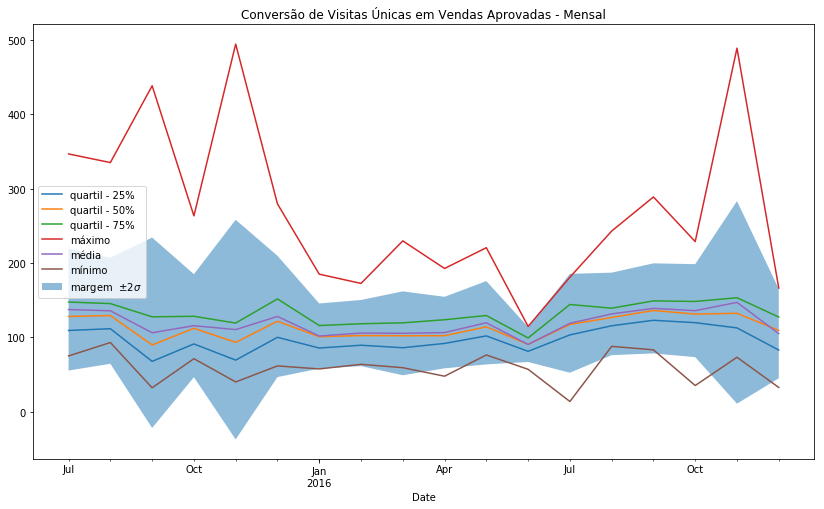

In [33]:
describe_simple_plot (indicator_medias[media][1][period][sumary][base, output], indicator_title);

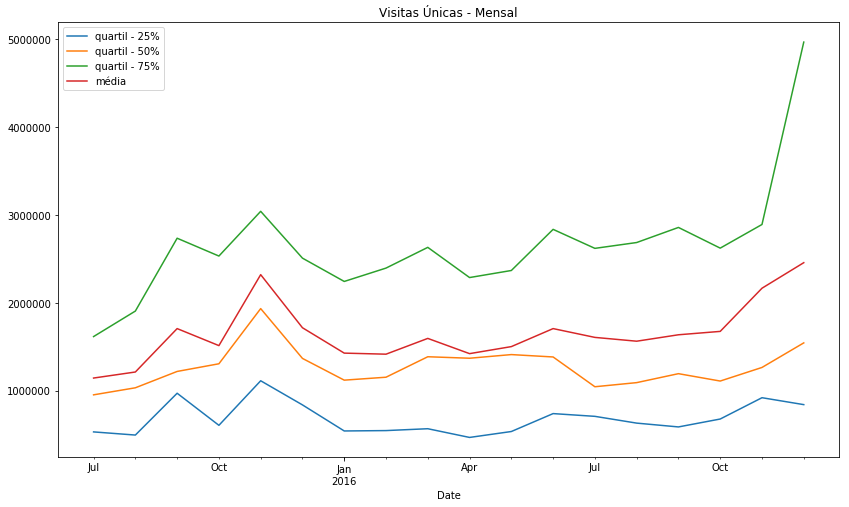

In [34]:
data_table.index.set_levels (sumary_periods[period], level='Date', inplace=True)
describe_simple_plot (data_table.loc[media][base].groupby (level=-1).describe (), base_title, 
                      non_extrm_plot_labels)

In [35]:
treated_anomalies += [[media, brand] for media in [2,4,5] for brand in Brands]

In [36]:
data_table.index.set_levels (Dates, level=-1, inplace=True)

## $\qquad$ Sequências localizadas de zeros ou valores pequenos.
            
            Afetam os canais '0', '6' e '7' e ocorrem em trechos curtos e espalhados. Portanto, a princípio, podem ser apenas ignorados ou substituídos por uma regressão. Então será possível obter-se todas as estatísticas pretendidas desses canais. 

In [37]:
loc_zeros = [[media, brand] for media in Medias for brand in Brands 
             if [media, brand] not in treated_anomalies and 
             (data_table.abs ().loc[media, brand] < 1000).any ().any ()]

zero_anomalies += loc_zeros
print ('    Canais e marcas com ocorrências localizadas de entradas abaixo de 1000\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in loc_zeros)))

    Canais e marcas com ocorrências localizadas de entradas abaixo de 1000

Canal 0, marca 2;
Canal 6, marca 0;
Canal 6, marca 1;
Canal 6, marca 2;
Canal 7, marca 0;
Canal 7, marca 1;
Canal 7, marca 2;



In [38]:
zero_periods = {(media, brand):(data_table.abs ().loc[media, brand] < 1000).any (axis=1) for media, brand in loc_zeros}

Segue uma amostra da anomalia:

In [39]:
media, brand = 6, 0
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
6     0     2016-07-01         0.0   332136.0         103712.0   
            2016-07-02         0.0   277774.0          73696.0   
            2016-07-03         0.0   247618.0          65184.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
6     0     2016-07-01         12912650.08       19160084.24   
            2016-07-02          8524451.76       14638576.48   
            2016-07-03          7658003.76       12361333.60   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
6     0     2016-07-01         12912650.08          30536.0            22176.0  
            2016-07-02          8524451.76          23936.0            16280.0  
            2016-07-03          7658003.76          22352.0            15576.0

 $\qquad$ Numa inspeção mais cuidadosa da anomalia no canal '7', no entanto, nota-se um padrão peculiar

In [40]:
media, brand = 7, 0
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]][:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
7     0     2015-11-07         0.0    19446.0           7602.0   
            2015-11-08         0.0    16338.0           6958.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
7     0     2015-11-07           867469.68        1318088.64   
            2015-11-08           182658.96         645578.56   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
7     0     2015-11-07           867469.68           1584.0              880.0  
            2015-11-08           182658.96           1056.0              528.0

 $\qquad$ Os valores em todas as colunas são abaixo do esperado se comparados com a amostra anterior. Isto pode se dever ao fato de que não houve investimentos em marketing neste momento. Portanto no caso do canal 7 trata-se de uma anomalia que, apesar de localizada, não se assemelha a um evento de ausência arbtrária de eventos. Nesse caso, toda a linha é anôma-la.

 $\qquad$ Procede-se ao tratamento destas anomalias localizadas, via regressão.

   Primeiro os canais exceto '7':

Amostra do resultado

 $\qquad$ Trecho com anomalia:

In [41]:
media, brand = 6, 0
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]][:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
6     0     2016-07-01         0.0   332136.0         103712.0   
            2016-07-02         0.0   277774.0          73696.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
6     0     2016-07-01         12912650.08       19160084.24   
            2016-07-02          8524451.76       14638576.48   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
6     0     2016-07-01         12912650.08          30536.0            22176.0  
            2016-07-02          8524451.76          23936.0            16280.0

In [42]:
sample_len = 10

for media, brand in loc_zeros[:-3]:
    current_table = data_table['Investment'].loc[media, brand]

    for ts in Dates[zero_periods[media, brand]]:
        current_table[ts] = current_table.sample (sample_len).mean ()

 $\qquad$ Trecho corrigido:

In [43]:
media, brand = 6, 0
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]][:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                   
6     0     2016-07-01  3.695032e+07   332136.0         103712.0   
            2016-07-02  1.502844e+07   277774.0          73696.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
6     0     2016-07-01         12912650.08       19160084.24   
            2016-07-02          8524451.76       14638576.48   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
6     0     2016-07-01         12912650.08          30536.0            22176.0  
            2016-07-02          8524451.76          23936.0            16280.0

 $\qquad$ Trecho sem anomalia:

In [44]:
media, brand = 6, 0
data_table.loc (axis=0)[media, brand, Dates[:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
6     0     2015-07-01   2212760.0  1566698.0         397516.0   
            2015-07-02   8347504.0  4744502.0        1294734.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
6     0     2015-07-01        4.680522e+07      6.926414e+07   
            2015-07-02        1.951928e+08      2.914167e+08   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
6     0     2015-07-01        4.680522e+07         151360.0           114400.0  
            2015-07-02        1.951928e+08         583440.0           429968.0

 $\qquad$ Agora o canal '7'

Amostra do resultado

 $\qquad$ Trecho com anomalia:

In [45]:
media, brand = 7, 0
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]][:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
7     0     2015-11-07         0.0    19446.0           7602.0   
            2015-11-08         0.0    16338.0           6958.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
7     0     2015-11-07           867469.68        1318088.64   
            2015-11-08           182658.96         645578.56   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
7     0     2015-11-07           867469.68           1584.0              880.0  
            2015-11-08           182658.96           1056.0              528.0

In [46]:
sample_len = 10

for media, brand in loc_zeros[-3:]:
    current_table = data_table.loc[media, brand]
    
    for ts in Dates[zero_periods[media, brand]]:
        current_table.loc[ts] = current_table.sample (sample_len).mean ()

 $\qquad$ Trecho corrigido:

In [47]:
media, brand = 7, 0 
data_table.loc (axis=0)[media, brand, Dates[zero_periods[media, brand]][:2], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                   
7     0     2015-11-07  3.272178e+06  1328460.0         718895.8   
            2015-11-08  3.766741e+06  1495534.6         866069.4   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
7     0     2015-11-07        1.093247e+07      2.293499e+07   
            2015-11-08        1.238236e+07      2.855710e+07   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
7     0     2015-11-07        1.093247e+07          48373.6            29075.2  
            2015-11-08        1.238236e+07          50450.4            29180.8

 $\qquad$ Trecho sem anomalia:

In [48]:
media, brand = 7, 0
data_table.loc (axis=0)[media, brand, Dates[10:12], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                 
7     0     2015-07-11    764139.2   385266.0         186858.0   
            2015-07-12    724037.6   357322.0         169414.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
7     0     2015-07-11          5476895.60       10590912.64   
            2015-07-12          6130915.12        9305489.60   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
7     0     2015-07-11          5476895.60          19272.0            12144.0  
            2015-07-12          6130915.12          17776.0            12320.0

## $\quad$ Viabilidade dos Indicadores

 $\qquad$ Com as anomalias apropriadamente corrigidas, procede-se para uma amostra dos indicadores. Como toda a extensão dos dados está disponível, todos os indicadores possíveis podem ser gerados.

In [49]:
indicators_base = ('Investment', 'NumVisits', 'NumUniqueVisits')

In [50]:
indicator_medias[6] = ratio_and_stats_tables (6, indicators_base, indicators_comparison, sumary_periods)
indicator_medias[7] = ratio_and_stats_tables (7, indicators_base, indicators_comparison, sumary_periods)

 $\qquad$ Como também há ocorrência de valores negativos no canal '0', este será analisado adiante.

Segue uma amostra dos indicadores para o canal '7'

In [51]:
media = 7
period, sumary = 'monthly', 'overall'
base, output = 'Investment', 'GrossSalesApproved'

In [52]:
indicator_title = 'Conversão de {:s} em {:s} - '.format (column_labels[base], column_labels[output]) + period_labels[period]

In [53]:
base_title = column_labels[base] + ' - ' + period_labels[period]

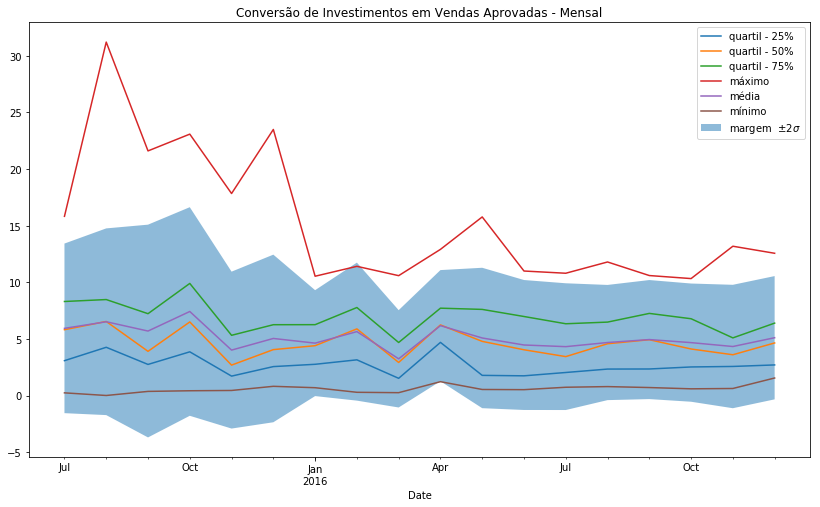

In [54]:
describe_simple_plot (indicator_medias[media][1][period][sumary][base, output], indicator_title);

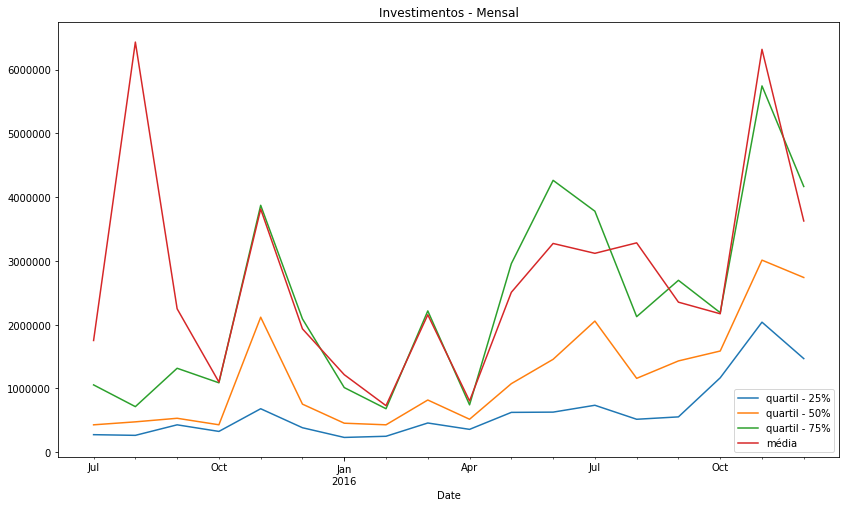

In [55]:
data_table.index.set_levels (sumary_periods[period], level='Date', inplace=True)
describe_simple_plot (data_table.loc[media][base].groupby (level=-1).describe (), base_title, 
                      non_extrm_plot_labels)

In [56]:
treated_anomalies += [[media, brand] for media in [6, 7] for brand in Brands]

In [57]:
data_table.index.set_levels (Dates, level=-1, inplace=True)

## $\qquad$ Valores negativos nas tabelas

 $\qquad$ As ocorrências são confinadas aos canais '0' e '1' e apenas nas colunas de investimentos.    

In [58]:
negatives = [[media, brand] for media in Medias for brand in Brands
             if (data_table.loc[media, brand] < 0).any ().any ()]

other_anomalies += negatives
print ('    Canais e marcas com ocorrências de entradas negativas:\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in negatives)))

    Canais e marcas com ocorrências de entradas negativas:

Canal 0, marca 0;
Canal 0, marca 1;
Canal 0, marca 2;
Canal 1, marca 1;



In [59]:
neg_periods = {(media, brand): (data_table.loc[media, brand] < 0).any (axis=1) for media, brand in negatives}

Segue uma amostra da anomalia:

In [60]:
media, brand = 0, 1
data_table.loc (axis=0)[media, brand, Dates[neg_periods[media, brand]], :]

Investment  NumVisits  NumUniqueVisits  \
Media Brand Date                                                   
0     1     2016-01-01 -1.587458e+06   405860.0         169288.0   
            2016-02-01 -1.087795e+06   438284.0         187236.0   
            2016-03-02 -2.909772e+06   309778.0         102802.0   
            2016-05-04 -2.423986e+06   546280.0         222082.0   
            2016-11-12 -5.532825e+06   468958.0         155792.0   

                        GrossSalesEstimate  GrossSalesPlaced  \
Media Brand Date                                               
0     1     2016-01-01         19546811.68       40833426.48   
            2016-02-01         12955052.88       21356526.40   
            2016-03-02          7721608.40       17283968.24   
            2016-05-04         28014887.12       44165069.52   
            2016-11-12         29539928.88       48859016.80   

                        GrossSalesApproved  QtyOrdersPlaced  QtyOrdersApproved  
Media Brand Date                                                                
0     1     2016-01-01         19546811.68          62568.0            35200.0  
            2016-02-01         12955052.88          53416.0            36344.0  
            2016-03-02          7721608.40          35728.0            21472.0  
            2016-05-04         28014887.12          75944.0            49456.0  
            2016-11-12         29539928.88          89848.0            60544.0

## $\quad$ Viabilidade dos Indicadores

 $\quad$ As ocorrências dessa anomalia são esparsas. Numa inspeção mais cuidadosa, nota-se o seguinte padrão:
                
 $\qquad$ Se tais valores de investimentos são convertidos para valores positivos, tornam-se valores de investimento dentro das margens dos demais valores de investimento.
        
 $\qquad$ Há também a seguinte ressalva: tais valores parecem corresponder, quase sempre, aos valores cujo retorno foi abaixo do esperado. No entanto, como há outras ocorrências de tais momentos nas demais datas, não consideraremos uma anomalia, apenas um erro de sinal no valor.
 
 $\quad$ Assim sendo, corrige-se os valores da tabela para valores positivos e calcula-se todos os indicadores.

In [61]:
numpy.abs (data_table.as_matrix (), out=data_table.as_matrix ());

Trecho corrigido:

In [62]:
media, brand = 1, 1
data_table.loc (axis=0)[media, brand, Dates[neg_periods[media, brand]], :]

,,,Investment,NumVisits,NumUniqueVisits,GrossSalesEstimate,GrossSalesPlaced,GrossSalesApproved,QtyOrdersPlaced,QtyOrdersApproved
Media,Brand,Date,,,,,,,,
1,1,2016-02-01,2759944.0,554694.0,307566.0,32438144.64,47062287.36,32438144.64,75504.0,57024.0


In [63]:
indicators_base = ('Investment', 'NumVisits', 'NumUniqueVisits')

In [64]:
indicator_medias[0] = ratio_and_stats_tables (0, indicators_base, indicators_comparison, sumary_periods)
indicator_medias[1] = ratio_and_stats_tables (1, indicators_base, indicators_comparison, sumary_periods)

Segue uma amostra dos indicadores para o canal '1'

In [65]:
media = 1
period, sumary = 'monthly', 'overall'
base, output = 'Investment', 'NumVisits'

In [66]:
indicator_title = 'Conversão de {:s} em {:s} - '.format (column_labels[base], column_labels[output]) + period_labels[period]

In [67]:
base_title = column_labels[base] + ' - ' + period_labels[period]

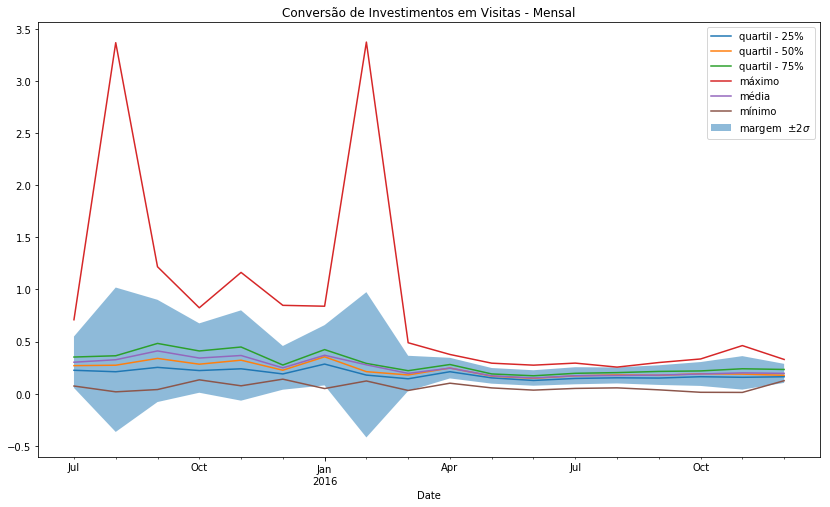

In [68]:
describe_simple_plot (indicator_medias[media][1][period][sumary][base, output], indicator_title);

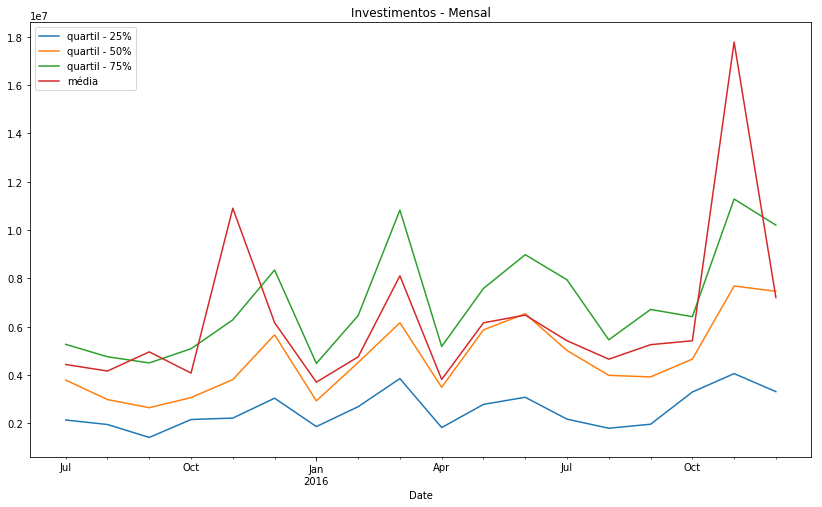

In [69]:
data_table.index.set_levels (sumary_periods[period], level='Date', inplace=True)
describe_simple_plot (data_table.loc[media][base].groupby (level=-1).describe (), base_title, 
                      non_extrm_plot_labels)

In [70]:
treated_anomalies += [[media, brand] for media in [0,1] for brand in Brands]

In [71]:
data_table.index.set_levels (Dates, level=-1, inplace=True)

# $\quad$ Após esse processo de tratamento, restam apenas as estatísticas dos dados não-anômalos.

In [72]:
no_anomalies = [[media, brand] for media in Medias for brand in Brands 
               if [media, brand] not in treated_anomalies]
print ('    Canais e marcas sem ocorrências de anomalias:\n')
print (''.join (('Canal {:d}, marca {:d};\n'.format (media, brand) for media, brand in no_anomalies)))

    Canais e marcas sem ocorrências de anomalias:

Canal 3, marca 0;
Canal 3, marca 1;
Canal 3, marca 2;



 $\qquad$ Isto é, apenas do canal 3.

In [73]:
indicators_base = ('Investment', 'NumVisits', 'NumUniqueVisits')

In [74]:
indicator_medias[3] = ratio_and_stats_tables (3, indicators_base, indicators_comparison, sumary_periods)

In [75]:
indicator_tables, indicator_statisctics = ratio_and_stats_tables (media, indicators_base, 
                                                                  indicators_comparison, 
                                                                  sumary_periods)

Segue adiante uma amostra de seus indicadores.

In [76]:
media = 3
period, sumary = 'monthly', 'overall'
base, output = 'Investment', 'NumVisits'

In [77]:
indicator_title = 'Conversão de {:s} em {:s} - '.format (column_labels[base], column_labels[output]) + period_labels[period]

In [78]:
base_title = column_labels[base] + ' - ' + period_labels[period]

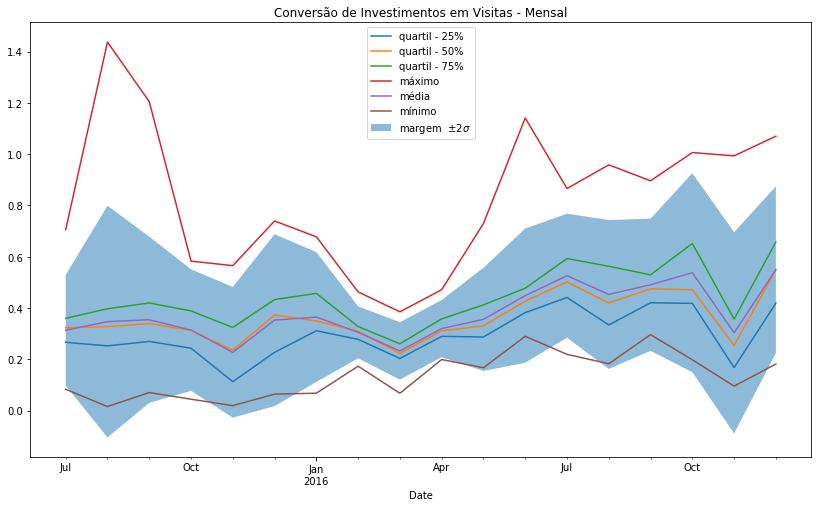

In [79]:
describe_simple_plot (indicator_medias[media][1][period][sumary][base, output], indicator_title);

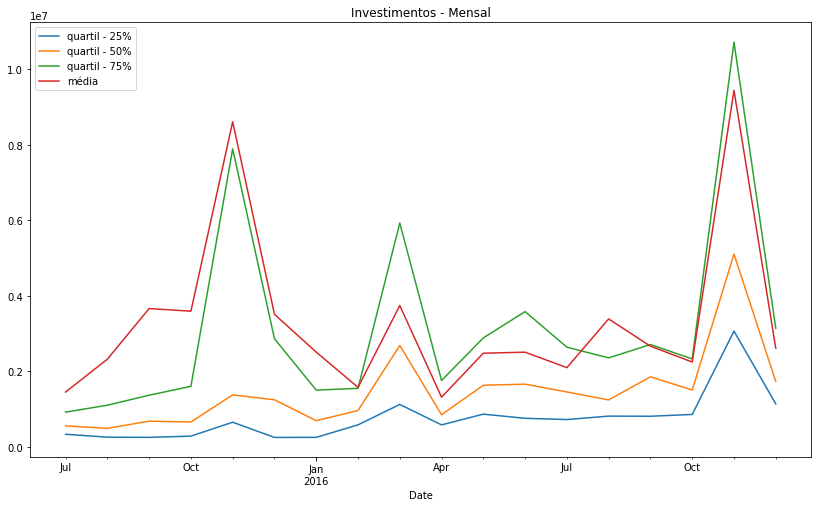

In [80]:
data_table.index.set_levels (sumary_periods[period], level='Date', inplace=True)
describe_simple_plot (data_table.loc[media][base].groupby (level=-1).describe (), base_title, 
                      non_extrm_plot_labels)

In [81]:
data_table.index.set_levels (Dates, level='Date', inplace=True)

# $\quad$ Análise e comparações

 $\qquad$ Realizado o tratamento dos dados e em mãos das tabelas de estatísticas de indicadores, comparativos podem ser estabelecidos entre os desempenhos de cada canal e cada marca.

In [82]:
print ('    Canais disponíves para análise:\n')
print (''.join (('{:d}, '.format (key) for key in indicator_medias.keys ())))

    Canais disponíves para análise:

2, 4, 5, 6, 7, 0, 1, 3, 


## $\qquad$ Indicador de Vendas por Visita

 $\qquad$ Nos termos desta análise, conversão de Número de visitas em vendas aprovadas. Quantifica a capacidade bruta do canal de converter uma visitação em vendas para o canal. Não quantifica diretamente o retorno, mas pode ser visto como potencial para. Além disso está disponível para todos os canais exceto '8' e '9'.

Um comparativo das tendências médias trimestrais:

In [83]:
period, sumary = 'monthly', 'overall'
base, output = 'NumVisits', 'GrossSalesApproved'

In [84]:
indicator_title = 'Conversão de {:s} em {:s} entre canais - '.format (column_labels[base], column_labels[output]) + period_labels[period] + '\nMédias'

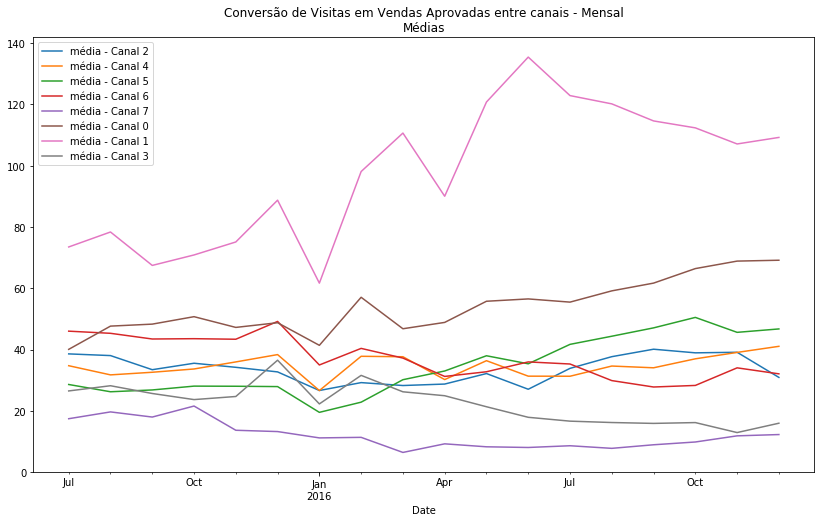

In [85]:
fig = figure (figsize=(14, 8))
ax = fig.gca ()

for media in indicator_medias.keys ():
    media_statisctics = indicator_medias[media][1][period][sumary][base, output]
    
#     cmp_plot_labels = {'50%': 'quartil - 50% - Canal {:d}'.format (media) , 
#                        'mean': 'média - Canal {:d}'.format (media)}

    cmp_plot_labels = {'mean': 'média - Canal {:d}'.format (media)}
    
    describe_simple_plot (media_statisctics, indicator_title, cmp_plot_labels, ax)

 $\qquad$ Em termos de tendência média, o canal '1' sobrepuja significativamente os demais. Todavia, apesar da margem vasta, vale a pena estudar a volatilidade durante o período. Isso dado que, fora o canal '1', as têndecias dos demais canais são próximas, relativamente. Portanto, a variância torna-se um fator de escolha relevante, pois dita o risco envolvido na escolha.

In [86]:
indicator_title = 'Conversão de {:s} em {:s} entre canais - '.format (column_labels[base], column_labels[output]) + period_labels[period] + '\nEscala de variância'

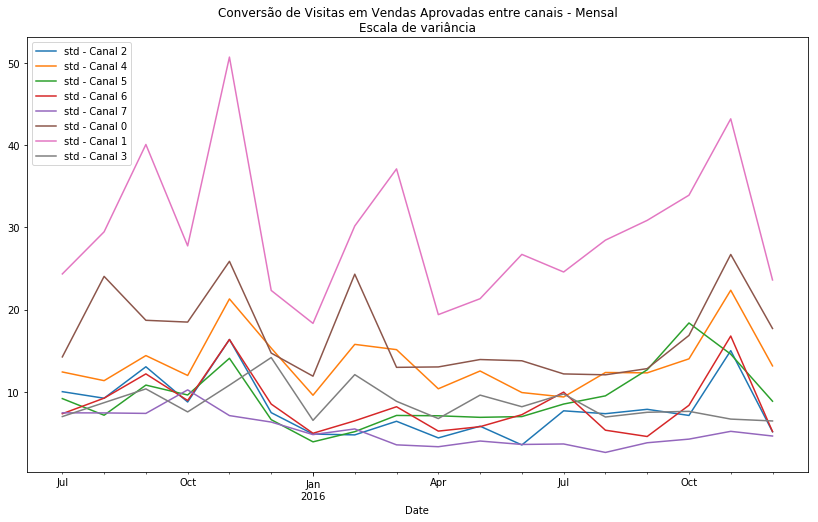

In [87]:
fig = figure (figsize=(14, 8))
ax = fig.gca ()

for media in indicator_medias.keys ():
    
    media_statisctics = indicator_medias[media][1][period][sumary][base, output]

    cmp_plot_labels = {'std': 'std - Canal {:d}'.format (media)}
    
    describe_simple_plot (media_statisctics, indicator_title, cmp_plot_labels, ax, non_margin_std=True)

 $\qquad$ A volatilidade do canal '1', assim como sua tendência média, estão numa escala diferente das demais, portanto, o potencial de retorno é deveras distinto das demais. Para que haja clareza no comparativo entre os menores, a volatilidade do canal '1' será omitida.

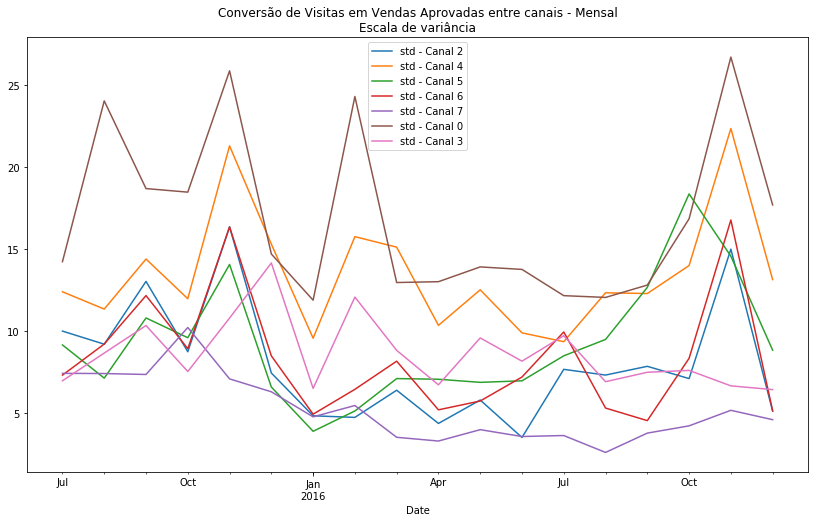

In [88]:
fig = figure (figsize=(14, 8))
ax = fig.gca ()

for media in indicator_medias.keys ():
    
    if media == 1:

        continue
    
    media_statisctics = indicator_medias[media][1][period][sumary][base, output]

    cmp_plot_labels = {'std': 'std - Canal {:d}'.format (media)}
    
    describe_simple_plot (media_statisctics, indicator_title, cmp_plot_labels, ax, non_margin_std=True)

 $\qquad$ De fato, ainda que os gráficos sejam crus, nota-se eventos não trivias quanto a volatilidade. O canal '0', que possui das melhores tendências médias, também possui das maiores volatilidades. Já o canal 6, bem próximo, possui das menores.

 $\qquad$ Numa inspeção mais cuidadosa, mas ainda qualitativa, até janeiro de 2016, o canal '6' compensara em volatilidade se comparado ao '0'. No entanto, mais para o fim de 2016, mesmo com alta volatilidade, o canal '0' passava a compensar devido a têndencia superior. Ou seja, nesse caso, mesmo sob uma escolha mais conservadora, a volatilidade compensa para o canal '0'.

In [89]:
indicator_title = 'Conversão de {:s} em {:s} entre canais - '.format (column_labels[base], column_labels[output]) + period_labels[period] + '\nComparativo de Volatilidade'

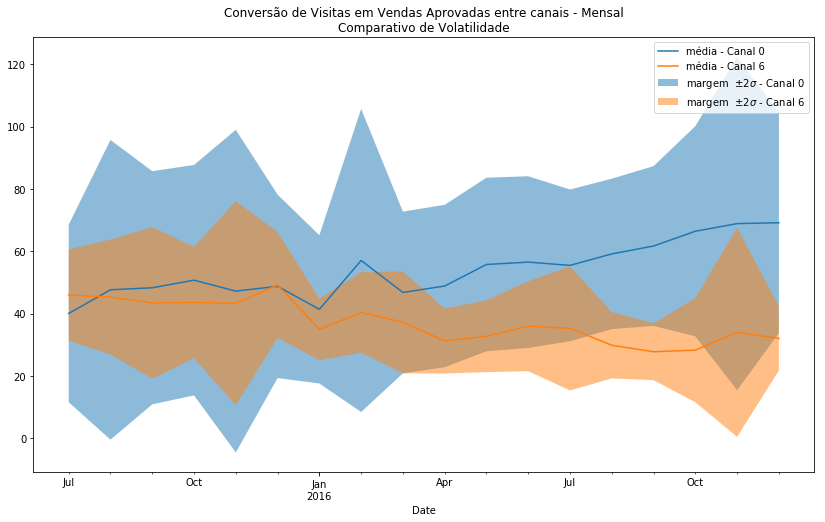

In [90]:
fig = figure (figsize=(14, 8))
ax = fig.gca ()

sigma_multiple = 2

for media in [0, 6]:
    media_statisctics = indicator_medias[media][1][period][sumary][base, output]
    
    cmp_plot_labels = {'mean': 'média - Canal {:d}'.format (media), 
                       'std': 'margem  $\pm{:d}\sigma$ - Canal {:d}'.format (sigma_multiple, media)}
    
    describe_simple_plot (media_statisctics, indicator_title, cmp_plot_labels, ax)

 $\qquad$ Ainda sim, globalmente, o canal '1', com volatilidade vastamente superior aos demais, ainda possui o melhor potencial progressivamente. Nota-se também o canal '3', que possui das menores tendências, mas também baixìssima volatilidade. Ainda sim, um risco deveras alto, devido a escala da volatilidade se comparada a sua tendência.

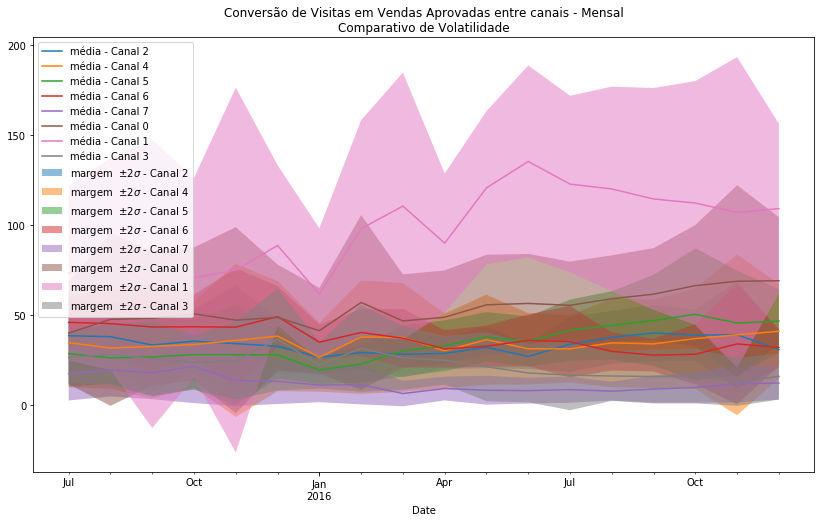

In [91]:
fig = figure (figsize=(14, 8))
ax = fig.gca ()

sigma_multiple = 2

for media in indicator_medias.keys ():
    media_statisctics = indicator_medias[media][1][period][sumary][base, output]
    
    cmp_plot_labels = {'mean': 'média - Canal {:d}'.format (media), 
                       'std': 'margem  $\pm{:d}\sigma$ - Canal {:d}'.format (sigma_multiple, media)}
    
    describe_simple_plot (media_statisctics, indicator_title, cmp_plot_labels, ax)

# $\qquad$ Parecer final

 $\qquad$ Esses são algumas das análises possíveis a partir dos sumários de conversão. Em mãos dessas informações de tendência e volatilidade, tanto em investimentos quanto em tráfego, é possível estabelecer-se modelos de portifólios periódicos que os levem em consideração.
        
 $\qquad$ Um portifólio simples, oriententado a balanco entre volatilidade e tendência média poderia ser estabelecido para todos os canais disponíveis. Um mais sofisticado, introduziria também a capacidade dos investimentos de gerar tráfego, quando disponível. Além disso, esses poderiam ser especializador por marca, conforme a distinção fosse cabível.
        
 $\qquad$ O processo de tratamento dos dados tomou tempo vasto, portanto uma modelagem estruturada para um portifólio não foi possível. Além disso, outras informações de campo sobre a natureza do investimento a serem inqueridas, corroborariam para uma modelagem mais condizente com os interesses do investidor. Portanto, tal modelagem fica para um trabalho futuro.